##### Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# R-U-SURE Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/r_u_sure/r_u_sure/notebooks/R_U_SURE_Demo.ipynb)

This notebook demonstrates how to use R-U-SURE to combine multiple code suggestions from a generative model of code.

## Setup

### Installation

To run this notebook, you need a Python environment with `r_u_sure` installed. 

If you are running this from Colab, you can install it by running the following command:

In [ ]:
try:
  import r_u_sure
except ImportError:
  try:
    import google.colab
    in_colab = True
  except ImportError:
    in_colab = False
  
  if in_colab:
    print("Installing r_u_sure from GitHub...")
    !pip install "r_u_sure @ git+https://github.com/google-research/r_u_sure"
  else:
    # Don't install in this case, to avoid messing up the python environment.
    print("WARNING: Not running in Colab and r_u_sure not found. "
          "Please install r_u_sure following the instructions in the README.")
    raise

### Imports

In [ ]:
import numpy as np
from IPython import display

%matplotlib inline

from r_u_sure.notebooks import demo_examples
from r_u_sure.wrappers import demo_runner

from r_u_sure.wrappers import uncertainty_regions_wrapper
from r_u_sure.wrappers import prefix_truncation_wrapper
from r_u_sure.wrappers import call_sequence_wrapper

## Combining model samples

The first step is to configure the R-U-SURE system for the task you want to accomplish. There are three task wrappers that make it easy to run in the three configurations described in the paper:

- `UncertaintyRegionsWrapper` (denoted  R-U-SURE (Region) in our research paper) inserts UNSURE annotations around code that is likely to differ between the suggestion prototype and the user intent.
- `PrefixByEditDistanceWrapper` (denoted  R-U-SURE (Prefix) and R-U-SURE (Prefix+Region) in our research paper) chooses a truncation point to remove parts of the suggestion that are too uncertain, and can optionally also insert UNSURE annotations in the remaining suggestion.
- `ApiCallSequenceWrapper` (denoted  R-U-SURE (API) in our research paper) preprocesses the code suggestions to extract function and method calls, and then annotates the most-likely subset of those calls (and possibly their arguments and assigned variable names) as SURE.

For interactive use, we provide a `DemoRunner` class that makes it easier to use each of these wrappers.

In [ ]:
# Building the decision diagrams with numba is faster after JIT compilation,
# but has a slower startup time.
use_numba = False

# Try uncommenting a different wrapper to apply the approach to a
# different task.

# Put an UNSURE region around parts with less than 70% chance of being kept.
wrapper = uncertainty_regions_wrapper.UncertaintyRegionsWrapper(
    effective_precision=0.7,
    use_numba=use_numba,
)

# Truncate suggestion once the majority of the remaining suggestion is likely to
# be deleted.
# wrapper = prefix_truncation_wrapper.PrefixByEditDistanceWrapper(
#     use_numba=use_numba
# )

# Truncate suggestion and also add UNSURE regions.
# wrapper = prefix_truncation_wrapper.PrefixByEditDistanceWrapper(
#     use_numba=use_numba,
#     also_insert_uncertainty_regions=True,
# )

# Extract likely function and API calls from the suggestions.
# wrapper = call_sequence_wrapper.ApiCallSequenceWrapper(use_numba=use_numba)

In [ ]:
# We support python, cpp, java, and javascript. You can also use "simple" to
# just perform simple bracket matching.
runner = demo_runner.DemoRunner(wrapper, language="python")

The next step is to collect:
- the context, represented as the contents of a file up until a particular cursor position,
- a set of model suggestions returned by a generative model of code, conditioned on the context. It should be possible to concatenate each of these suggestions to the context to obtain a valid continuation of the context. *(Note: Our parser is error-tolerant, so it's OK if the model suggestions end in the middle of an expression or statement. However, it is assumed that the **first part** of each suggestion is parseable when concatenated with the context.)*

For this demo, we've collected a few contexts with the corresponding outputs of a code generative model. You can also insert outputs of any other generative model here, or add logic to query a generative model through an API.

In [ ]:
print(list(demo_examples.MODEL_OUTPUTS.keys()))

['token_conf_json', 'sqlite_matplotlib', 'mbpp_24', 'mbpp_61', 'jax_optax']


In [ ]:
demo_example_key = "mbpp_61"
context, model_samples = demo_examples.get_context_and_sources(demo_example_key)

In [ ]:
print("=" * 80 + "\ncontext\n" + "=" * 80)
print(context)
print("=" * 80 + "\nsample 0\n" + "=" * 80)
print(model_samples[0])
print("=" * 80 + "\nsample 1\n" + "=" * 80)
print(model_samples[1])

context

# Write a python function to count number of substrings with the sum of digits equal to their length.

from collections import defaultdict
def count_Substrings(s,n):
    count,sum = 0,0
    mp = defaultdict(lambda : 0)
    mp[0] += 1
sample 0

    for i in range(0,n):
        sum += s[i]
        count += mp[sum]
        mp[sum] += 1
    return count

print(count_Substrings("abc",4))

sample 1

    for i in range(n):
        sum += s[i]
        mp[sum] += 1
        count += mp[sum]
    return count



Now we can pass these inputs to the selected task wrapper and use it to generate a suggestion. By default, our demo runner uses the *first* sample as the suggestion prototype; the suggestion will always be derived from this first sample. (This can be customized using the `prototype_index` argument.)

For interactive use, you may want to only process a subset of the samples, since building the decision diagrams for additional samples leads to longer runtime. (There will also be some warm-up time for the first call, as the relevant functions are jit-compiled.)

In [ ]:
max_num_samples = 8

combine_result = runner.combine(
    context=context,
    samples=model_samples[:max_num_samples],
    prototype_index=0,
)

In [ ]:
runner.show_suggestion(combine_result)

The output above is the formatted version of the suggestion, and the "︙" token represents a location that code might need to be inserted (a length-zero UNSURE region).

We can also extract the suggestion as a list of tagged substrings of the form `(substring, is_unsure)`:

In [ ]:
runner.get_extracted_parts(combine_result)

[('\n', False),
 ('', True),
 ('    for i in range(', False),
 ('0,n', True),
 ('):\n        sum += ', False),
 ('s[i]\n        count += mp[sum]\n', True),
 ('        mp[sum] += 1', False),
 ('', True),
 ('\n    return count\n\n', False),
 ('print(count_Substrings("abc",4))\n', True)]

And, for each model sample, we can visualize the inferred edits between the suggestion and that sample. (Note: Whitespace is ignored when computing edits, so the formatting below may not be correct. Also, ፠ denotes the start of an inferred edit, which is used to handle localization penalties and track insertions.)

In [ ]:
runner.show_edits(combine_result)

We can similarly inspect the utility of our suggestion against each of the hypothetical user intents (the other samples).

In [ ]:
runner.show_utilities(combine_result)

Target 0: 72.6
Target 1: 14.6
Target 2: 31.1
Target 3: -14.4
Target 4: 29.6
Target 5: 17.6
Target 6: 36.6
Target 7: 27.1


We can also inspect the convergence of the optimization algorithm. The dashed line represents the utility of the solution we found, averaged over all samples. The blue line shows convergence of the dual bound as we perform coordinate descent on each variable.

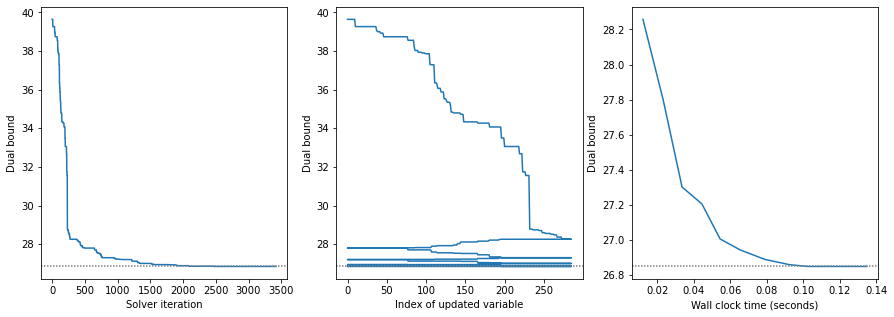

In [ ]:
runner.show_optimization_details(combine_result)

If desired, we can inspect the raw decision diagram vector assignments, which are what are produced by the combinatorial optimization solver. (This is a low level representation of the selected suggestion, and isn't intended to be particularly meaningful alone. For more details on what it means, see the notebook [`Utility_decision_diagrams_details.ipynb`](https://colab.research.google.com/github/google-research/r_u_sure/r_u_sure/notebooks/Utility_decision_diagrams_details.ipynb).)

In [ ]:
# Raw assignment vector.
combine_result.assignment_vector

array([0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1,
       0, 2, 0, 1, 0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 1,
       0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 2, 0, 0, 2, 1, 2, 1, 0, 1,
       2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2,
       0, 1, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 2, 0, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1,
       0, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0,
       1, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0,
       1, 0, 2, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 2, 0, 2])

In [ ]:
# Limit the size of the output area.
display.display(display.Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})'))

combine_result.assignment_map

<IPython.core.display.Javascript object>

{DecisionKey(prototype_preorder_index=0, category=<DecisionCategory.NODE_IN_REGION: 3>): <DecisionValue.FALSE: 1>,
 DecisionKey(prototype_preorder_index=1, category=<DecisionCategory.NODE_IN_REGION: 3>): <DecisionValue.FALSE: 1>,
 DecisionKey(prototype_preorder_index=2, category=<DecisionCategory.NODE_IN_REGION: 3>): <DecisionValue.FALSE: 1>,
 DecisionKey(prototype_preorder_index=3, category=<DecisionCategory.NODE_IN_REGION: 3>): <DecisionValue.FALSE: 1>,
 DecisionKey(prototype_preorder_index=4, category=<DecisionCategory.NODE_IN_REGION: 3>): <DecisionValue.FALSE: 1>,
 DecisionKey(prototype_preorder_index=5, category=<DecisionCategory.NODE_IN_REGION: 3>): <DecisionValue.FALSE: 1>,
 DecisionKey(prototype_preorder_index=6, category=<DecisionCategory.REGION_SHOULD_END: 2>): <DecisionValue.NOT_APPLICABLE: 3>,
 DecisionKey(prototype_preorder_index=8, category=<DecisionCategory.REGION_SHOULD_START: 1>): <DecisionValue.FALSE: 1>,
 DecisionKey(prototype_preorder_index=9, category=<DecisionCate

## Token probabilities and baseline suggestions

If the generative model produces per-token conditional probabilities, we can use them to construct the baseline suggestions shown in the paper. For this demo, we'll just look it up in our saved results.

In [ ]:
context, model_samples_with_log_probs = demo_examples.get_context_and_token_probs(demo_example_key)
one_sample_with_log_probs = model_samples_with_log_probs[0]

We can then visualize the probabilities given by the model (here red denotes lower-confidence tokens):

In [ ]:
runner.show_token_probs(context, one_sample_with_log_probs, parse_and_realign=False)

Note that model tokens might not exactly align with parser tokens, so we first align arbitrary substring probabilities with the parser tokens. Here's the same output after applying our parser:

In [ ]:
runner.show_token_probs(context, one_sample_with_log_probs, parse_and_realign=True)

This is used to construct our baseline assignments.

Note the following correspondence to the names of the baselines in out research paper:
- `prob_threshold_x_nonempty` = "Token Prob. Thresh x"
- `prob_threshold_x_cumulative` = "Prefix Prob. Thresh x"
- `example_fraction_x` = "Example Fraction x"

In [ ]:
baseline_results = runner.build_baselines(context, one_sample_with_log_probs)

In [ ]:
for name, baseline_result in baseline_results.items():
  print(f"==== {name} ====")
  runner.show_suggestion(baseline_result)

==== prob_threshold_0.3_nonempty ====


==== prob_threshold_0.3_cumulative ====


==== prob_threshold_0.5_nonempty ====


==== prob_threshold_0.5_cumulative ====


==== prob_threshold_0.7_nonempty ====


==== prob_threshold_0.7_cumulative ====


==== prob_threshold_0.9_nonempty ====


==== prob_threshold_0.9_cumulative ====


==== example_fraction_0.0 ====


==== example_fraction_0.5 ====


==== example_fraction_1.0 ====
